NeuroLang Datalog Example based on the FMA Ontology and Neurosynth
=====================================================================


Uploading the FMA Ontology into NeuroLang and executing some simple queries.

For more information about FMA Ontology, visit:
https://bioportal.bioontology.org/ontologies/FMA

In [1]:
from neurosynth.analysis import meta
import nibabel as nib
import nilearn as nil
import numpy as np
from neurolang.frontend.fma_ontolgy_utils import FMAOntology
from neurolang import frontend as fe
from nilearn import plotting

#we use Owlready2 to parse the FMA ontology
#you can install cython first, to get an optimized version:
#pip install Cython
#pip install Owlready2

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/solver_datalog_naive.py:23: UserWarning: This module is being deprecated please use the datalog module
  warn("This module is being deprecated please use the datalog module")
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/expression_pattern_matching.py:87: UserWarning: Warning in class SolverNonRecursiveDatalogNaive overwrites ['fact', 'statement_intensional'] from base DatalogProgram[typing.Any]
  warn(warn_message)
/Users/gzanitti/Projects/INRIA/NeuroLang/

In [2]:
fma = FMAOntology()
fma.load_ontology()

nl = fe.NeurolangDL()
nl = fma.init_ontology(nl, destriuex_relations=True)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:132: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [3]:
@nl.add_symbol
def region_volume(region: fe.ExplicitVBR) -> float:
    volume = (
        len(region.voxels) *
        float(np.product(np.abs(np.linalg.eigvals(region.affine[:-1, :-1]))))
    )
    return volume

After load the ontology, we can try a simple query to test that everything is working well. 

Here we are retrieving all the subcategories that has 'Gyrus of parietal lobe' as a root

In [4]:
with nl.environment as e:
    res = nl.query(e.val(e.y), e.isSub('Gyrus of parietal lobe', e.y)) 
res

val: typing.AbstractSet[typing.Tuple[str]] = [('Right postcentral gyrus',), ('Left postcentral gyrus',), ('Right precuneus',), ('Left precuneus',), ('Right superior parietal lobule',), ('Left superior parietal lobule',), ('Right inferior parietal lobule',), ('Left inferior parietal lobule',)]

As the implementation is based on regions of the Desikan's atlas, we should be able to combine the results of the Ontolgy with Neurosynth to get access to specific regions.

We can use Neurosynth to obtain all the regions related with the term 'superior' in te atlas and use the ontology to get the ones that are related with an specific region.

In [5]:
neurosynth_superior = nl.load_neurosynth_term_regions(
    '*superior*',
    name='neurosynth_superior'
)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retv

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:132: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


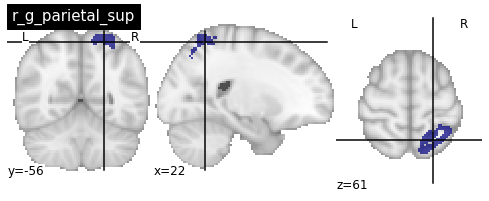

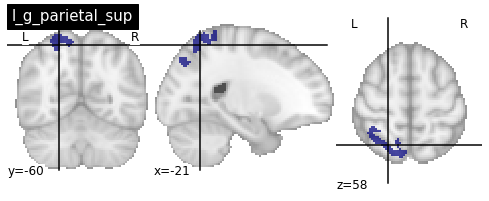

In [6]:
with nl.environment as e:
    res = nl.query(
        e.query(e.y, e.region_1),
        e.isSub('Gyrus of parietal lobe', e.x) & e.relation(e.y, e.x) &
        e.destrieux_regions(e.y, e.region_1) & e.neurosynth_superior(e.region_2) &
        (e.region_volume(e.region_2) > 1500) &
        nl.symbols.overlapping(e.region_1, e.region_2)
    )
    
for name, region in res.value:
    plotting.plot_roi(region.spatial_image(), title=name)

In [7]:
#with nl.environment as e:
#    res2 = nl.query(
#        e.query(e.y, e.region_1),
#        e.isSub('Gyrus of parietal lobe', e.x) & e.relation(e.y, e.x) &
#        e.destrieux(e.y, e.region_1) & e.neurosynth_superior(e.region_2) &
#        (e.region_volume(e.region_2) > 1500) &
#        nl.symbols.overlapping(e.region_1, e.region_2)
#    )
#for name, region in res2.value:
#    plotting.plot_roi(region.spatial_image(), title=name)

Or we can take advantage of the ontology to filter the regions provided for Neurosynth

In [8]:
neurosynth_occipitotemporal = nl.load_neurosynth_term_regions(
    'occipitotemporal',
    name='neurosynth_occipitotemporal'
)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Wi

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:132: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


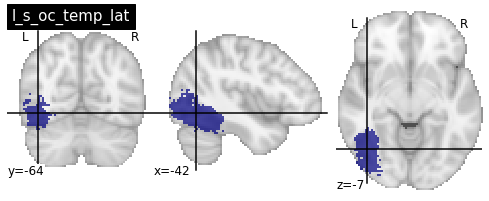

In [14]:
with nl.environment as e:
    res3 = nl.query(
        e.query(e.y, e.region_2),
        e.relation(e.y, 'Left occipitotemporal sulcus') &
        e.destrieux_regions(e.y, e.region_1) &
        e.neurosynth_occipitotemporal(e.region_2) &
        (e.region_volume(e.region_2) > 1500) &
        nl.symbols.overlapping(e.region_1, e.region_2)
    )
for name, region in res3.value:
    plotting.plot_roi(region.spatial_image(), title=name)

While without the use of the ontology we would have obtained more regions, maybe not related with the one that we are looking for

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:132: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


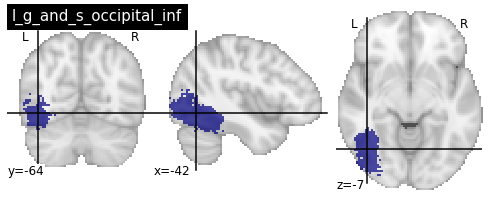

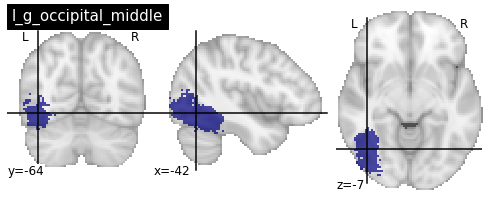

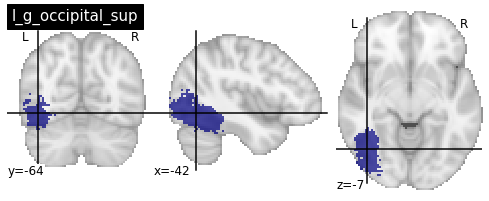

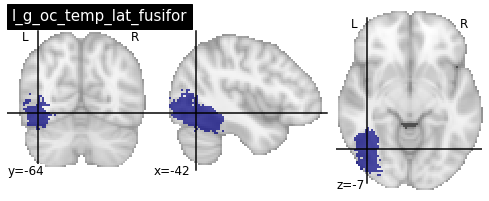

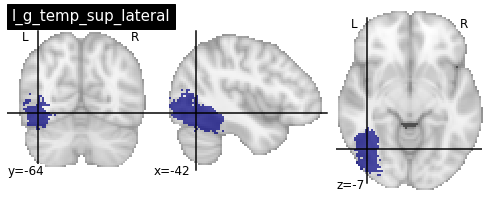

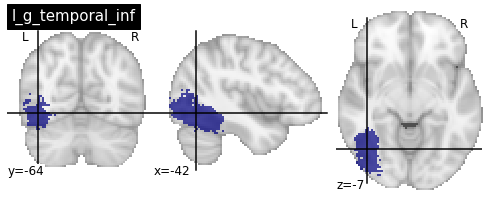

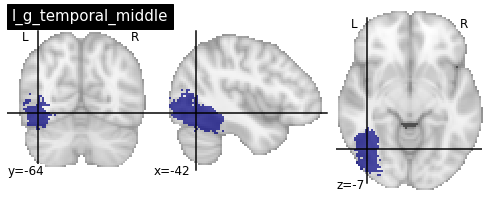

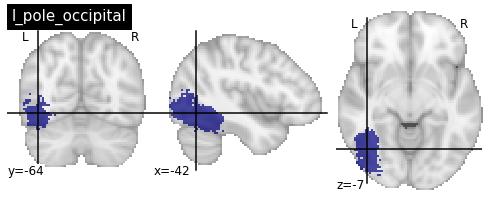

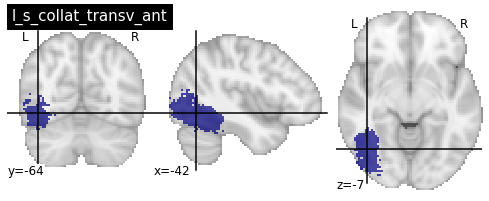

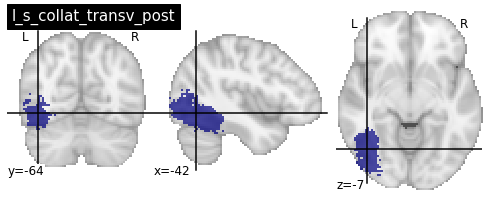

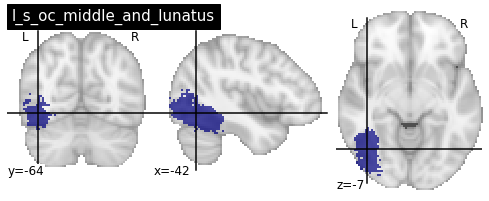

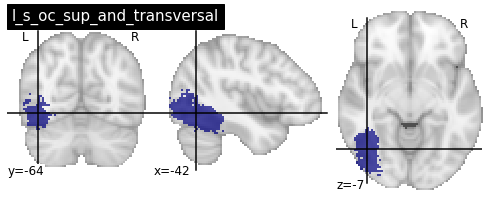

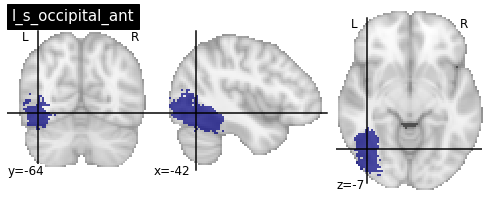

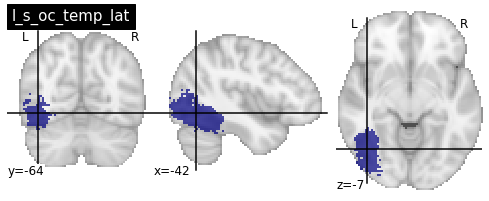

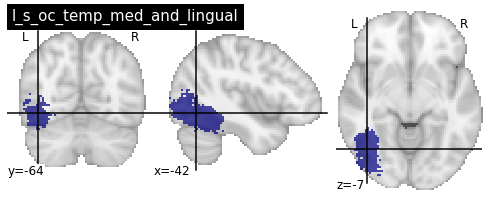

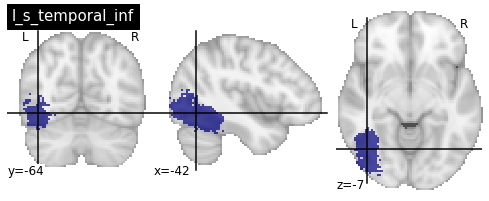

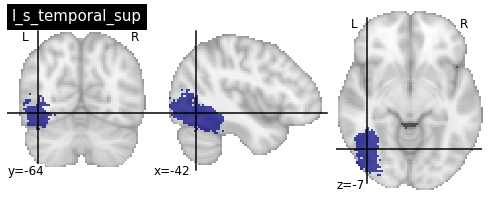

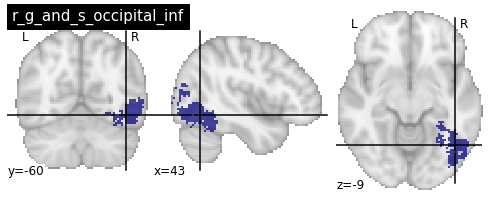

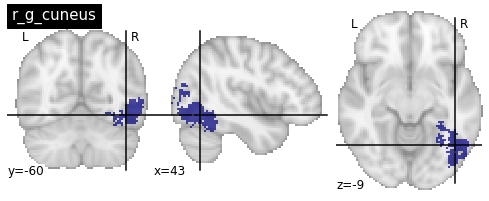

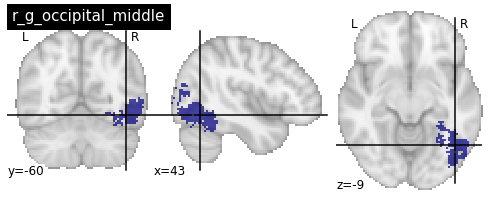

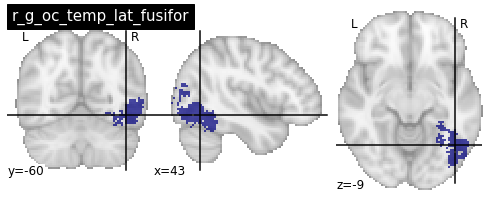

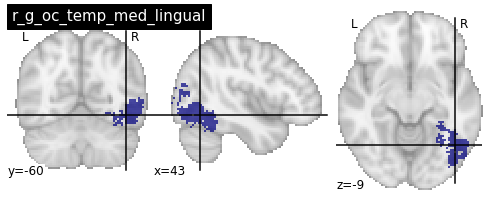

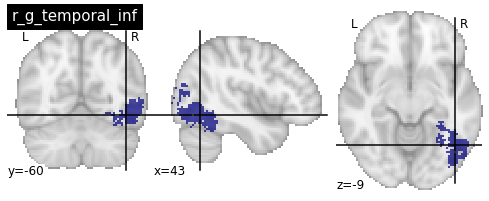

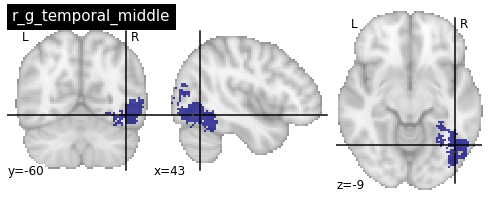

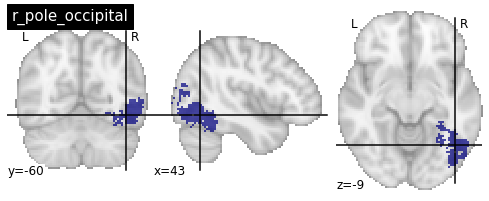

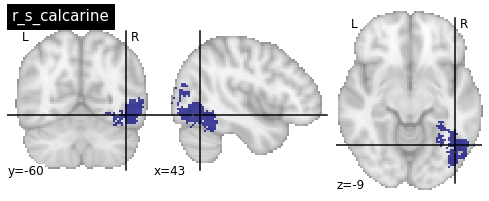

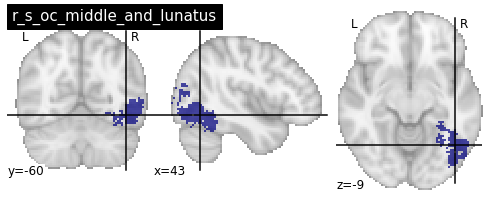

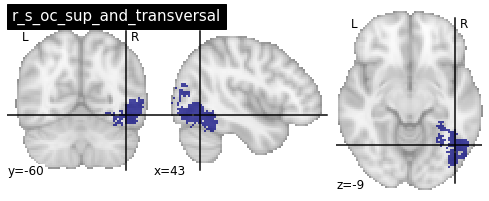

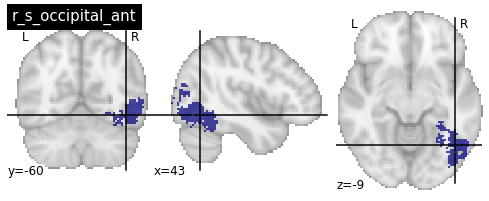

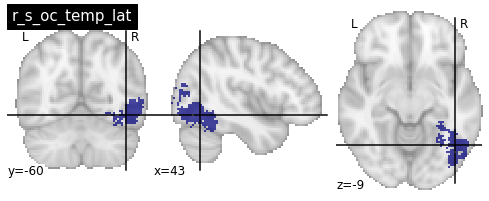

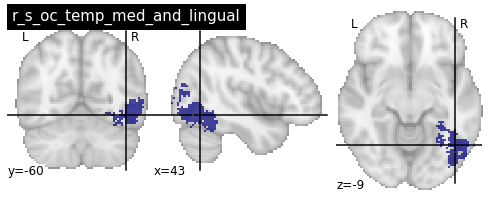

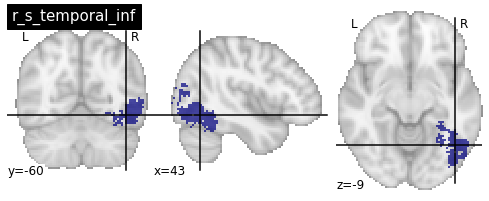

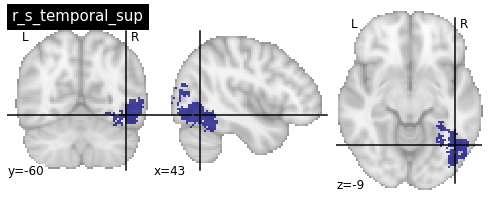

In [15]:
with nl.environment as e:
    res4 = nl.query(
        e.query(e.y, e.region_2),
        e.destrieux_regions(e.y, e.region_1) &
        e.neurosynth_occipitotemporal(e.region_2) &
        (e.region_volume(e.region_2) > 1500) &
        nl.symbols.overlapping(e.region_1, e.region_2)
    )

for name, region in res4.value:
    plotting.plot_roi(region.spatial_image(), title=name)

## More use cases will be added shortly.

In [267]:
import rdflib
g1 = rdflib.Graph()
g1.load('./fma.owl')

In [271]:
#g2 = rdflib.Graph()
#g2.load('./radlex.owl')

In [ ]:
#i = 0
#for e, p, v in g2:
#    print(str(e), str(p), str(v))
#    i += 1
#    if i == 100:
#        break

In [272]:
import pandas as pd
rows_list = []
for e, p, v in g1:
    if 'http' in e:
        #s = s.split('/')[-1]
        #p = p.split('#')[-1]
        dict1 = {'Entity': str(e), 'Property': str(p), 'Value': str(v)}
        rows_list.append(dict1)
        
#for e, p, v in g2:
#    if 'http' in e:
        #s = s.split('/')[-1]
        #p = p.split('#')[-1]
#        dict1 = {'Entity': str(e), 'Property': str(p), 'Value': str(v)}
#        rows_list.append(dict1)

df = pd.DataFrame(rows_list)

In [293]:
from neurolang import frontend as fe
nl = fe.NeurolangDL()
nl.add_tuple_set((tuple(e) for e in df.values), name='nodes');

In [294]:
triple = nl.new_symbol(name='triple')
w = nl.new_symbol(name='w')
x = nl.new_symbol(name='x')
y = nl.new_symbol(name='y')
z = nl.new_symbol(name='z')
triple[x,y,z] = nl.symbols.nodes(x,y,z)

In [295]:
query = nl.new_symbol(name='query')
nl.query(
    query(z, y),
    triple(x,'http://purl.org/sig/ont/fma/preferred_name',z) &
    triple(x,'http://purl.org/sig/ont/fma/DK__Freesurfer_',y)
)

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:132: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


query: typing.AbstractSet[typing.Tuple[str, str]] = [('Opercular part of left inferior frontal gyrus', '20'), ('CA1 field', '206'), ('Gray matter of left orbital gyrus', '1120'), ('Gray matter of left superior occipital gyrus', '1116'), ('Gray matter of left medial orbital gyrus', '1014'), ('Entorhinal area', '216'), ('Left nucleus accumbens', '26'), ('Fourth ventricle', '15'), ('Gray matter of left short insular gyrus', '1113'), ('White matter of left inferior occipital gyrus', '3114'), ('Right half of corpus callosum', '4101'), ('Right half of corpus callosum', '4004'), ('White matter of right frontal pole', '4032'), ('Cortex of left insula', '1146'), ('White matter of left short insular gyrus', '3113'), ('Ventral part of precentral gyrus', '404'), ('White matter of right cuneus', '4105'), ('White matter of right cuneus', '4005'), ('Optic chiasm', '85'), ('White matter of superior part of right precentral gyrus', '4173'), ('Gray matter of left superior parietal lobule', '1124'), ('Gr

In [296]:
destrieux_dataset = datasets.fetch_atlas_destrieux_2009()
destrieux_map = nib.load(destrieux_dataset['maps'])

d1 = []
d2 = []
for label_number, name in destrieux_dataset['labels']:
    if label_number == 0:
        continue
    name = name.decode()
    region = nl.create_region(
        destrieux_map, label=label_number
    )
    if region is None:
        continue
    name = name.replace('-', '_').replace(' ', '_').lower()
    d1.append((name, region))
    d2.append((name, label_number))

nl.add_tuple_set(((
    name,
    region,
) for name, region in d1),name='destrieux_regions');

nl.add_tuple_set(((
    name,
    label_number,
) for name, label_number in d2), name='destrieux_labels');

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [297]:
region = nl.new_symbol(name='region')
nl.query(
    query(z, region),
    triple(x,'http://purl.org/sig/ont/fma/preferred_name',z) &
    triple(x,'http://purl.org/sig/ont/fma/DK__Freesurfer_',y) &
    nl.symbols.destrieux_labels(w, y) &
    nl.symbols.destrieux_regions(w, region)
)

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:132: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [298]:
d1

[('l_g_and_s_frontomargin', Region(VBR= affine:[[   2.    0.    0.  -76.]
   [   0.    2.    0. -109.]
   [   0.    0.    2.  -64.]
   [   0.    0.    0.    1.]], voxels:[[19 81 26]
   [19 82 27]
   [19 82 28]
   ...
   [34 85 24]
   [34 85 25]
   [34 86 23]])),
 ('l_g_and_s_occipital_inf', Region(VBR= affine:[[   2.    0.    0.  -76.]
   [   0.    2.    0. -109.]
   [   0.    0.    2.  -64.]
   [   0.    0.    0.    1.]], voxels:[[14 14 26]
   [14 14 27]
   [14 15 26]
   ...
   [28 12 25]
   [28 12 26]
   [28 13 26]])),
 ('l_g_and_s_paracentral', Region(VBR= affine:[[   2.    0.    0.  -76.]
   [   0.    2.    0. -109.]
   [   0.    0.    2.  -64.]
   [   0.    0.    0.    1.]], voxels:[[27 32 69]
   [27 33 65]
   [27 33 66]
   ...
   [37 45 69]
   [37 46 68]
   [37 46 69]])),
 ('l_g_and_s_subcentral', Region(VBR= affine:[[   2.    0.    0.  -76.]
   [   0.    2.    0. -109.]
   [   0.    0.    2.  -64.]
   [   0.    0.    0.    1.]], voxels:[[ 4 47 41]
   [ 4 48 39]
   [ 4 48 40]
   

In [299]:
d2

[('l_g_and_s_frontomargin', 1),
 ('l_g_and_s_occipital_inf', 2),
 ('l_g_and_s_paracentral', 3),
 ('l_g_and_s_subcentral', 4),
 ('l_g_and_s_transv_frontopol', 5),
 ('l_g_and_s_cingul_ant', 6),
 ('l_g_and_s_cingul_mid_ant', 7),
 ('l_g_and_s_cingul_mid_post', 8),
 ('l_g_cingul_post_dorsal', 9),
 ('l_g_cingul_post_ventral', 10),
 ('l_g_cuneus', 11),
 ('l_g_front_inf_opercular', 12),
 ('l_g_front_inf_orbital', 13),
 ('l_g_front_inf_triangul', 14),
 ('l_g_front_middle', 15),
 ('l_g_front_sup', 16),
 ('l_g_ins_lg_and_s_cent_ins', 17),
 ('l_g_insular_short', 18),
 ('l_g_occipital_middle', 19),
 ('l_g_occipital_sup', 20),
 ('l_g_oc_temp_lat_fusifor', 21),
 ('l_g_oc_temp_med_lingual', 22),
 ('l_g_oc_temp_med_parahip', 23),
 ('l_g_orbital', 24),
 ('l_g_pariet_inf_angular', 25),
 ('l_g_pariet_inf_supramar', 26),
 ('l_g_parietal_sup', 27),
 ('l_g_postcentral', 28),
 ('l_g_precentral', 29),
 ('l_g_precuneus', 30),
 ('l_g_rectus', 31),
 ('l_g_subcallosal', 32),
 ('l_g_temp_sup_g_t_transv', 33),
 ('l_

In [178]:
i = 0
for triples in onto.get_triples():
    print(triples)
    i += 1
    if i == 15:
        break

(302, 6, 80)
(302, 308, 307)
(309, 6, 15)
(310, 6, 15)
(311, 6, 15)
(313, 6, 15)
(314, 6, 15)
(315, 6, 15)
(316, 6, 15)
(317, 6, 15)
(317, 8, 60)
(318, 6, 15)
(319, 6, 15)
(-1, 6, 83)
(-1, 309, 320)


In [177]:
print(list(onto.classes())[302].label, list(onto.properties())[6].label)

['Second dorsal metacarpal artery'] ['days post-fertilization', 'days post-fertilization']


In [167]:
import ontospy
model = ontospy.Ontospy('./owlapi.xrdf', build_all=False)

     xml:base="http://www.w3.org/2002/07/owl"
     xmlns:metadata="http://data.bioontology.org/metadata/"
     xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
     xmlns:owl="http://www.w3.org/2002/07/owl#"
     xmlns:xml="http://www.w3.org/XML/1998/namespace"
     xmlns:xsd="http://www.w3.org/2001/XMLSchema#"
     xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
     xmlns:fma="http://purl.org/sig/ont/fma/"
     xmlns:dc="http://purl.org/dc/elements/1.1/" does not look like a valid URI, trying to serialize this will break.
     xml:base="http://www.w3.org/2002/07/owl"
     xmlns:metadata="http://data.bioontology.org/metadata/"
     xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
     xmlns:owl="http://www.w3.org/2002/07/owl#"
     xmlns:xml="http://www.w3.org/XML/1998/namespace"
     xmlns:xsd="http://www.w3.org/2001/XMLSchema#"
     xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
     xmlns:fma="http://purl.org/sig/ont/fma/"
     xmlns:dc="http://purl.org/dc/elem

----------
TIP: You can try one of the following RDF validation services
<http://mowl-power.cs.man.ac.uk:8080/validator/validate>
<http://www.ivan-herman.net/Misc/2008/owlrl/>


In [165]:
model

In [139]:
onto['319']

In [115]:
for p in onto.properties():
    if p.FMAID:
        print(p.FMAID)
    else:
        print(p)

['85844']
['85873']
['85880']
['85991']
fma.anatomical_coordinate
['85981']
['300889']
['85827']
['293329']
['85914']
['85912']
fma.has_direct_cell_layer
fma.has_direct_number_of_pairs_per_nucleus
fma.has_direct_ploidy
['85911']
['85913']
fma.laterality
['85867']
['281388']
['85856']
['85900']
['85834']
['85919']
['85861']
['85862']
['85964']
['85923']
['85846']
['85938']
['276391']
['85924']
['85989']
['85988']
['85987']
fma.anatomical_entity_observed
fma.anatomical_landmark_for
fma.has_anatomical_landmark
['85838']
['305861']
['85841']
fma.anteroinferior_to
fma.anterolateral_to
fma.anteromedial_to
fma.anterosuperior_to
['85863']
['86003']
['276393']
['85882']
['85883']
['85937']
['293326']
['85853']
['85936']
['85850']
['85992']
['86004']
['85994']
['85996']
['85973']
['85997']
['85922']
['85921']
['85925']
['85927']
['85995']
['85848']
['85835']
['85857']
['85975']
['85976']
['85972']
fma.corresponds_to
['293346']
['293345']
['229553']
['229557']
['293327']
['300893']
['300888']
['3

In [98]:
for an in onto[]
    print(an)

fma.AP_position
fma.Latin_name__TA_
fma.action_type
fma.adjacent
fma.anatomical_coordinate
fma.cell_appendage_type
fma.days_post-fertilization
fma.dimension
fma.gestation_age__weeks_
fma.has_boundary
fma.has_dimension
fma.has_direct_cell_layer
fma.has_direct_number_of_pairs_per_nucleus
fma.has_direct_ploidy
fma.has_inherent_3-D_shape
fma.has_mass
fma.laterality
fma.nerve_supply_type
fma.part_type
fma.partition
fma.percentage
fma.physical_state
fma.polarity
fma.rank_of_tissue
fma.species
fma.state
fma.state_of_determination
fma.superior-inferior_position
fma.view


In [14]:
node = onto.search(label = 'Left orbital gyrus')

In [19]:
for prop in onto.properties():
    print(prop)

fma.AP_position
fma.Latin_name__TA_
fma.action_type
fma.adjacent
fma.anatomical_coordinate
fma.cell_appendage_type
fma.days_post-fertilization
fma.dimension
fma.gestation_age__weeks_
fma.has_boundary
fma.has_dimension
fma.has_direct_cell_layer
fma.has_direct_number_of_pairs_per_nucleus
fma.has_direct_ploidy
fma.has_inherent_3-D_shape
fma.has_mass
fma.laterality
fma.nerve_supply_type
fma.part_type
fma.partition
fma.percentage
fma.physical_state
fma.polarity
fma.rank_of_tissue
fma.species
fma.state
fma.state_of_determination
fma.superior-inferior_position
fma.view
fma.adheres_to
fma.connected_to
fma.adjacent_to
fma.afferent_to
fma.efferent_to
fma.anatomical_entity_observed
fma.anatomical_landmark_for
fma.has_anatomical_landmark
fma.anatomical_plane
fma.anterior_to
fma.has_location
fma.anteroinferior_to
fma.anterolateral_to
fma.anteromedial_to
fma.anterosuperior_to
fma.arterial_supply
fma.arterial_supply_of
fma.articulates_with
fma.attaches_to
fma.receives_attachment_from
fma.attributed_c

In [26]:
node[0].DK__Freesurfer_

[]

In [43]:
nodes = get_nodes(onto, 'Postnatal anatomical structure')

In [93]:
for node in nodes:
    if node.DK__Freesurfer_ != []:
        print(node.label, node.DK__Freesurfer_)

['Brainstem'] ['16']
['Presubiculum'] ['204']
['Subiculum'] ['205']
['Parasubiculum'] ['203']
['Fusiform gyrus'] ['222']
['Parahippocampal gyrus'] ['222']
['Right insula'] ['55']
['Left insula'] ['19']
['Triangular part of inferior frontal gyrus'] ['403']
['Ventral part of precentral gyrus'] ['404']
['Dorsal part of precentral gyrus'] ['405']
['Middle part of precentral gyrus'] ['406']
['Right subiculum'] ['199']
['Left subiculum'] ['195']
['Dentate gyrus of hippocampus'] ['210']
['Right superior frontal gyrus'] ['84']
['Left superior frontal gyrus'] ['83']
['Left fusiform gyrus'] ['1007']
['Right paraterminal gyrus'] ['2120']
['Left paraterminal gyrus'] ['1129']
['Right hippocampus proper'] ['53']
['Left hippocampus proper'] ['17']
['Opercular part of right inferior frontal gyrus'] ['56']
['Opercular part of left inferior frontal gyrus'] ['20']
['Orbital part of right inferior frontal gyrus'] ['64']
['Orbital part of left inferior frontal gyrus'] ['32']
['Polar part of right superior 

In [91]:
nodes[2].DK__Freesurfer_

['16']

In [47]:
from nilearn import datasets
import nibabel as nib
destrieux_dataset = datasets.fetch_atlas_destrieux_2009()
destrieux_map = nib.load(destrieux_dataset['maps'])

In [64]:
destrieux_dataset

{'maps': '/Users/gzanitti/nilearn_data/destrieux_2009/destrieux2009_rois_lateralized.nii.gz',
 'labels': rec.array([(  0, b'Background'), (  1, b'L G_and_S_frontomargin'),
            (  2, b'L G_and_S_occipital_inf'),
            (  3, b'L G_and_S_paracentral'),
            (  4, b'L G_and_S_subcentral'),
            (  5, b'L G_and_S_transv_frontopol'),
            (  6, b'L G_and_S_cingul-Ant'),
            (  7, b'L G_and_S_cingul-Mid-Ant'),
            (  8, b'L G_and_S_cingul-Mid-Post'),
            (  9, b'L G_cingul-Post-dorsal'),
            ( 10, b'L G_cingul-Post-ventral'), ( 11, b'L G_cuneus'),
            ( 12, b'L G_front_inf-Opercular'),
            ( 13, b'L G_front_inf-Orbital'),
            ( 14, b'L G_front_inf-Triangul'), ( 15, b'L G_front_middle'),
            ( 16, b'L G_front_sup'), ( 17, b'L G_Ins_lg_and_S_cent_ins'),
            ( 18, b'L G_insular_short'), ( 19, b'L G_occipital_middle'),
            ( 20, b'L G_occipital_sup'), ( 21, b'L G_oc-temp_lat-fusifor'